In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline
from scipy.interpolate import interp2d
from glob import glob
import os, sys
sys.path.append("/net/carney/home/naomi/mymodules")
from TCC.TDMAsolver import TDMAsolver
from ingrid.smooth121 import Smooth121

# Make changes here ----------
eps_days = 0.75
K_days = 10
efrac = 2.   # multiply epsu by efrac to get epsv
Hq = 2000    
PrcpLand = 1 # use data precip trends over land

wnspmin = 5; rhoair = 0.3
delta = 0.78
nx = 180; ny = 60
YN = 60; YS=-YN

basedir = 'tmp/S91-'
outfile = basedir+'K'+str(K_days)+'-eps'+str(eps_days)+'-Hq'+str(Hq)+'-PrcpLand'+str(PrcpLand)+'.nc'

if not os.path.isdir("tmp"):
    os.makedirs("tmp")

NumberIterations = 10

In [2]:
gravity = 9.8; ZT = 15000; Th00 = 300; NBSQ = 3.0e-4
rEarth = 6.37e6; omega2 =  2* (2* np.pi/ 86400); L = 2.5e6
cpair = 1000

B = gravity * np.pi / (NBSQ * Th00 * ZT)
eps = 1./(eps_days * 86400)
epsu = eps
epsv = efrac*eps
K1 = B/(K_days*86400)
epsp =(np.pi/ZT)**2/(NBSQ*K_days*86400)
beta = omega2/rEarth

# make grids
dx = 360/nx; dy = (YN-YS)/ny
Yv = np.linspace(YS+dy/2, YN-dy/2, ny)
X = np.linspace(0,360 - dx,nx)
Yu = np.linspace(YS+dy, YN-dy, ny-1)
Yi = np.linspace(YS+3*dy/2, YN-3*dy/2, ny-2)
dX =  X[1]- X[0]; dY = Yv[1]-Yv[0]
dxm = dX*rEarth*np.pi/180
dym = dY*rEarth*np.pi/180
dym2 = dym*dym 

def fcor(Y):
    return omega2*Y*np.pi/180

fcu = fcor(Yu)

In [3]:
# need to have the correct ordering of the wave numbers for fft
N=nx
if N % 2 == 0:
    Kk = np.asarray(list(range(0, N // 2)) + [0] + list(range(-N // 2 + 1, 0)), np.float64)
else:
    Kk = np.asarray(list(range(0, (N - 1) // 2)) + [0] + list(range(-(N - 1) // 2, 0)), np.float64)

In [4]:
def f_qa(ts,sp):
    # ts: sst in Kelvin
    # sp: surface pressure in mb
    # return qs: surface specific humidity
    es0 = 6.11
    efac = 0.622    
    es = es0* np.exp(17.67*(ts-273.15)/((ts-273.15) + 243.5))
    return efac*delta*es/sp 

def f_E(mask,qa,wnsp):
    # qa: surface air humidity
    # wnsp: surface windspeed in m/s
    # return Evap in kg/m^2/s
    rhoair = 1.225
    CsE = 0.0015*(1+mask/2)
    #CsE = 0.0012
    return CsE*rhoair*(1-delta)*qa*wnsp/delta

def f_MC(qa,u,v):
    from scipy.fftpack import fft, ifft
    # qa: surface air humidity
    # u,v: low level winds in m/s (N.B., v is on Yv points, u,q are on Yu points)
    # return Moisture Convergence in kg/m^2/s
    rhoair = 1.225
    qu = qa*u
    qux = ifft(1.j*Kk*fft(qu)/rEarth).real
    Aq = (qa[1:ny-1,:] + qa[0:ny-2,:])/2.0
    qv = Aq*v[1:ny-1,:]
    z = np.zeros((1,nx))
    qv = np.concatenate((z,qv,z), axis=0) 
    #qvy = qv.diff('Yu')/dym
    qvy = (qv[1:ny,:] - qv[0:ny-1,:])/dym
    return -Hq*(qux + qvy)*rhoair

In [5]:
def S91_solver(Q1):
    from scipy.fftpack import fft, ifft
    Q1t = fft(Q1)
    fQ = fcu[:,np.newaxis]*Q1t
    AfQ = (fQ[1:ny-1,:] + fQ[0:ny-2,:])/ 2.0
    km = Kk/rEarth
    DQ = (Q1t[1:ny-1,:] - Q1t[0:ny-2,:])/dym
    rk = 1.j*km*beta - epsu*epsv*epsp - epsv*km**2
    fcp = fcu[1:ny-1]**2/ 4.0
    fcm = fcu[0:ny-2]**2/ 4.0
    
    ak = epsu/dym2 - epsp* fcm[:,np.newaxis]
    ck = epsu/dym2 - epsp* fcp[:,np.newaxis] 
    bk = -2*epsu/dym2 - epsp* (fcm[:,np.newaxis] + fcp[:,np.newaxis]) + rk[np.newaxis,:]
    dk = (-epsu*DQ + 1.j*km[np.newaxis,:]*AfQ)
    
    vtk = TDMAsolver(nx,ny-2,ak,bk,ck,dk)
    
    z = np.zeros((1,nx))
    vt = np.concatenate((z,vtk,z), axis=0)
    Av = (vt[1:ny,:] + vt[0:ny-1,:])/2.0
    fAv = fcu[:,np.newaxis]*Av
    Dv = (vt[1:ny,:] - vt[0:ny-1,:])/dym
    coeff = epsu*epsp + km*km
    ut = (epsp*fAv + 1.j*(Q1t + Dv)*km[np.newaxis,:])/coeff[np.newaxis,:]
    phit = -(Q1t + 1.j*ut*km[np.newaxis,:] + Dv)/epsp
    v = ifft(vt).real
    u = ifft(ut).real
    phi = ifft(phit).real
    return (u,v,phi)

In [6]:
# Define the new Dataset
ds = xr.Dataset({'X': ('X', X), 'Yu': ('Yu', Yu), 'Yv': ('Yv', Yv)})
ds.X.attrs = [('units','degree_east')]
ds.Yu.attrs = [('units','degree_north')]
ds.Yv.attrs = [('units','degree_north')]

ds['K'] = K_days; ds.K.attrs = [('units','day')]
ds['epsu'] = eps_days; ds.epsu.attrs = [('units','day')]
ds['epsv'] = eps_days/efrac; ds.epsv.attrs = [('units','day')]
ds['Hq'] = Hq; ds.Hq.attrs = [('units','m')]

In [7]:
url = r'http://carney.ldeo.columbia.edu:81/home/.TCC/.naomi/.data/'

dsClim = xr.open_dataset(url+ 'wnsp-clim.nc/dods')
fwnsp = interp2d(dsClim.X, dsClim.Y, dsClim.wnsp, kind= 'linear')
ds['wnspClim'] = (['Yu', 'X'], fwnsp(X, Yu))

dsClim = xr.open_dataset(url+ 'ts-clim.nc/dods')
fts = interp2d(dsClim.X, dsClim.Y, dsClim.ts, kind= 'linear')
ds['tsClim'] = (['Yu', 'X'], fts(X, Yu))

dsClim = xr.open_dataset(url+ 'pr-clim.nc/dods')
fpr = interp2d(dsClim.X, dsClim.Y, dsClim.pr, kind= 'linear')
ds['prClim'] = (['Yu', 'X'], fpr(X, Yu))

dsClim = xr.open_dataset(url+ 'sp-clim.nc/dods')
fsp = interp2d(dsClim.X, dsClim.Y, dsClim.sp, kind= 'linear')
ds['spClim'] = (['Yu', 'X'], fsp(X, Yu))

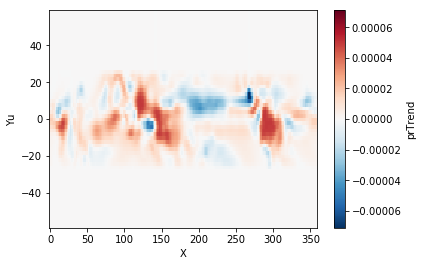

In [8]:
dsTrend = xr.open_dataset(url+ 'ts-ORAS4-trend.nc/dods')
ftsTrend = interp2d(dsTrend.X, dsTrend.Y, dsTrend.ts, kind='linear')
tsTrend = ftsTrend(X,Yu)
#tsTrend[abs(Yu)>25] = 0
ds['tsTrend'] = (['Yu','X'], tsTrend)

dsTrend = xr.open_dataset(url+ 'pr-ECMWF-trend.nc/dods')
fprTrend = interp2d(dsTrend.X, dsTrend.Y, dsTrend.pr, kind='linear')
prTrend = fprTrend(X,Yu)
prTrend[abs(Yu)>25] = 0
prTrend[prTrend>5e-5] = 5e-5
ds['prTrend'] = (['Yu','X'], prTrend)
#ds['prTrend']  = Smooth121(ds.prTrend, ['Yu'], NSmooths=1 )
ds['prTrend'] = Smooth121(ds.prTrend, ['Yu', 'X'], perdims=['X'])
ds.prTrend.plot()

In [9]:
# might want to smooth noisy climatological fields, (I don't think it is needed)
#ds['wnspClim'] = Smooth121(ds.wnspClim, ['Yu', 'X'], perdims=['X'])
#ds['tsClim']   = Smooth121(ds.tsClim,   ['Yu', 'X'], perdims=['X'])
#ds['prClim']   = Smooth121(ds.prClim,   ['Yu', 'X'], perdims=['X'])
#ds['spClim']   = Smooth121(ds.spClim,   ['Yu', 'X'], perdims=['X'])
#ds['tsTrend']  = Smooth121(ds.tsTrend,  ['Yu', 'X'], perdims=['X'])
#ds['prTrend']  = Smooth121(ds.prTrend,  ['Yu', 'X'], perdims=['X'])

dsmask = xr.open_dataset(url+ 'landmask.nc/dods')
fmask = interp2d(dsmask.X, dsmask.Y, dsmask.mask, kind='linear')
ds['mask'] = (['Yu','X'], fmask(X,Yu))

tsClim = ds.tsClim.values
spClim = ds.spClim.values
wnspClim = ds.wnspClim.values
wnspClim[wnspClim<wnspmin] = wnspmin
mask = ds.mask.values

In [10]:
tsend = (ds.tsClim + (1- mask)* ds.tsTrend/2).values
tsbeg = (ds.tsClim - (1- mask)* ds.tsTrend/2).values
prend = (ds.prClim + ds.prTrend/2).values
prbeg = (ds.prClim - ds.prTrend/2).values
Qthend = K1*(tsend)/B
Qthbeg = K1*(tsbeg)/B

qaend = f_qa(tsend,spClim)
Eend = f_E(mask,qaend,wnspClim)
PRend = Eend
PRend[PRend<0] = 0

qabeg = f_qa(tsbeg,spClim)
Ebeg = f_E(mask,qabeg,wnspClim)
PRbeg = Ebeg
PRbeg[PRbeg<0] = 0

In [19]:
Qth = Qthend
PR = PRend
E1 = Eend
qa1 = qaend

#Find total PR, u and v at end
for repeat in range(0,NumberIterations):
    # Start main calculation
    Qc = np.pi* L* PR/ (2* cpair* rhoair* ZT)  # heating from precip
    Q1 = B* (Qc+ Qth)
    (u1, v1, phi1) = S91_solver(Q1)
    daMC = xr.DataArray(f_MC(qa1,u1, v1), dims= ['Yu', 'X'])
    MC1 = Smooth121(daMC, ['Yu',  'X'], perdims= ['X']).values
    if (PrcpLand):
        PR = (1- mask)* (MC1 + E1) + mask* prend
    else:
        PR = (1- mask)* (MC1 + E1)
    PR[PR < 0] = 0

uend = u1
vend = v1
phiend = phi1
PRend = PR

In [12]:
Qth = Qthbeg
PR = PRbeg
E1 = Ebeg
qa1 = qabeg

#Find total PR, u and v at beginning
for repeat in range(0,NumberIterations):
    # Start main calculation
    Qc = np.pi* L* PR/ (2* cpair* rhoair* ZT)  # heating from precip
    Q1 = B* (Qc+ Qth)
    (u1, v1, phi1) = S91_solver(Q1)
    daMC = xr.DataArray(f_MC(qa1,u1, v1), dims= ['Yu', 'X'])
    MC1 = Smooth121(daMC, ['Yu',  'X'], perdims= ['X']).values
    if (PrcpLand):
        PR = (1- mask)* (MC1 + E1) + mask* prbeg
    else:
        PR = (1- mask)* (MC1 + E1)
    PR[PR < 0] = 0

ubeg = u1
vbeg = v1
phibeg = phi1
PRbeg = PR

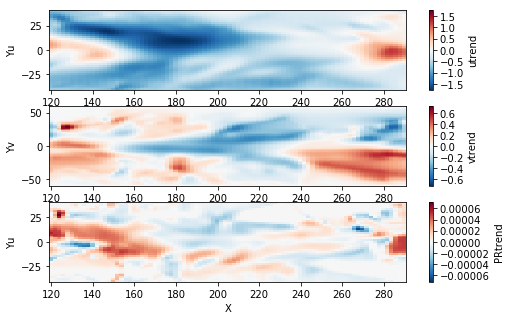

In [13]:
#save and plot the trends
ds['utrend'] = (['Yu','X'], uend-ubeg)
ds['vtrend'] = (['Yv','X'], vend-vbeg)
ds['phitrend'] = (['Yu','X'], phiend-phibeg)
ds['tstrend'] = (['Yu','X'], tsend-tsbeg)
ds['PRtrend'] = (['Yu','X'], PRend-PRbeg)
ds['Qthtrend'] = (['Yu','X'], Qthend-Qthbeg)

# There is 2 gridpoint noise in the phi field - so add a smooth in X:
ds['phitrend'] = Smooth121(ds.phitrend, ['X'], NSmooths=1, perdims=['X'])

ds_subset = ds.sel(X=slice(120,290),Yu=slice(-40,40))

plt.figure(figsize=(8,5))
plt.subplot(311)
ds_subset.utrend.plot(cmap="RdBu_r")
plt.subplot(312)
ds_subset.vtrend.plot(cmap="RdBu_r")
plt.subplot(313)
ds_subset.PRtrend.plot(cmap="RdBu_r")
#plt.savefig('S90-H2000-Stab.eps', format='eps', dpi=1000)

In [14]:
ds.utrend.attrs = [('units','m/s')]
ds.vtrend.attrs = [('units','m/s')]
ds.phitrend.attrs = [('units','m2/s2')]
ds.PRtrend.attrs = [('units','m/s')]
ds.Qthtrend.attrs = [('units','K/s')]

print(outfile)
dict = {'K': {'dtype': 'f4'},'epsu': {'dtype': 'f4'},'epsv': {'dtype': 'f4'},'Hq': {'dtype': 'f4'}}
ds.to_netcdf(outfile,encoding=dict)

tmp/S91-K10-eps0.75-Hq2000-PrcpLand1.nc
